##  Analysis of a claim
To Check on Checkability, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
#from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm
from tavily import TavilyClient
import sys
import os

# Load alle the API keys
load_dotenv(dotenv_path=".env", override=True)

# Initialize Tavily client 
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY", ""))

#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
#os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

#low temperature for more factual answers,
#llm = ChatOllama(model="qwen3:4b", temperature=0.1, base_url="http://localhost:11434")
llm = ChatGroq(model_name="qwen/qwen3-32b", temperature=0.1)

sys.path.append(os.path.abspath("./src"))

c:\temp\checkmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### AgentState and Pydantic schemes
The next part determines which data should be stored in AgentState (memory of the program), and how certain output should be structured using pydantic.

In [ ]:
#%%writefile ./src/state_scope.py

""" State Definitions and Pydantic Schemas for testing if a claim is checkable. """

from typing_extensions import TypedDict, Annotated, Sequence, Literal, List, Optional
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from operator import add as add_messages
from langgraph.graph.message import MessagesState


class AgentStateClaim(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    claim: str 
    checkable: Optional[bool]
    subject: Optional[str]
    quantitative: Optional[bool]
    precision: Optional[str]
    based_on: Optional[str]
    confirmed: bool
    question: Optional[str]
    alerts: List[str] = Field(default_factory=list)
    summary: Optional[str]

class AgentStateSource(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    claim: str 
    checkable: Optional[bool]
    subject: Optional[str]
    confirmed: bool
    search_queries:  List[str] = Field(default_factory=list)
    tavily_context: Optional[str]
    research_focus: Optional[str]
    research_results: List[str] = Field(default_factory=list)
    alerts: List[str] = Field(default_factory=list)
    summary: Optional[str]
    claim_url: Optional[str]
    claim_source: Optional[str]
    primary_source: Optional[bool]
    match: Optional[bool]
    explanation: Optional[str]


#output models for structured output
class SubjectResult(BaseModel):
    checkable: Literal["POTENTIALLY CHECKABLE", "UNCHECKABLE"]
    explanation: str = Field("", description="Explanation for the classification")
    question: str = Field("", description="Question to user for confirmation")

class MoreInfoResult(BaseModel):
    subject: str = Field("", description="The subject of the claim")
    quantitative: bool = Field(False, description="Is the claim quantitative?")
    precision: str = Field("", description="How precise is it?")
    based_on: str = Field("", description="how was the data collected or derived?")
    question: str = Field("", description="Question to user for clarification if needed")
    alerts: List[str] = Field([], description="Any alerts or warnings about the claim")

class SummaryResult(BaseModel):
    summary: str = Field("", description="A concise summary of the claim")
    question: str = Field("", description="Question to user for verification")
    subject: str = Field("", description="The subject of the claim")
    quantitative: bool = Field(False, description="Is the claim quantitative?")
    precision: str = Field("", description="How precise is it?")
    based_on: str = Field("", description="how was the data collected or derived?")
    question: str = Field("", description="Question to user for clarification if needed")
    alerts: List[str] = Field([], description="Any alerts or warnings about the claim")

class ConfirmationResult(BaseModel):
    confirmed: bool = Field(False, description="Whether the user confirmed the claim as checkable")

class ConfirmationFinalResult(BaseModel):
    confirmed: bool = Field(False, description="Whether the user confirmed the claim as checkable")
    subject: str = Field("", description="The subject of the claim")
    quantitative: bool = Field(False, description="Is the claim quantitative?")
    precision: str = Field("", description="How precise is it?")
    based_on: str = Field("", description="how was the data collected or derived?")
    question: str = Field("", description="Question to user for clarification if needed")
    alerts: List[str] = Field([], description="Any alerts or warnings about the claim")

class ConfirmationMatch(BaseModel):
    match: bool = Field(False, description="Whether the user confirmed their was a matching claim")
    explanation: str = Field("", description="Explanation of the matching")

class GetSource(BaseModel):
    claim_source: str = Field("", description="What is the source of this claim?")
    claim_url: str = Field("", description = "What is the url of this claim?")

class PrimarySourcePlan(BaseModel):
    claim_source: str = Field("", description="Best current source for the claim (URL, site, platform, etc.)")
    primary_source: bool = Field(False, description="True if the user already provided the original/official source")
    search_queries: List[str] = Field(default_factory=list, description="Ordered list of queries to run in Tavily to find the primary source")

class PrimarySourceSelection(BaseModel):
    primary_source: bool = Field(..., description="True if a credible/original source was found among the Tavily results.")
    claim_source: str = Field("", description="The best/most likely primary source (URL or title).")
    claim_url: str = Field("", description="The URL of the primary source if available, otherwise ''.")
    alerts: List[str] = Field([], description="Any alerts or warnings about the claim")

class ResearchPlan(BaseModel):
    research_queries: List[str] = Field([], description="Ordered list of search queries to run to gather evidence for the claim.")
    research_focus: str = Field("", description="What the research should focus on (e.g. fact checks, official statements, datasets).")


Overwriting ./src/state_scope.py


### Functions of all the nodes in Claim analysis

These functions are all the nodes in the claim graph and also show the edges in case of conditional nodes

In [ ]:
#%%writefile ./src/claim_nodes.py

"""Nodes for checking if a claim is potentially checkable."""

from langchain_core.messages import HumanMessage,AIMessage,get_buffer_string
from prompts import checkable_check_prompt,confirmation_checkable_prompt, get_information_prompt, confirmation_clarification_prompt, get_summary_prompt, confirmation_check_prompt
from state_scope import AgentStateClaim, SubjectResult, MoreInfoResult, SummaryResult, ConfirmationResult,ConfirmationFinalResult
from typing_extensions import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_FACT NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_fact(state: AgentStateClaim) -> Command[Literal["checkable_confirmation"]]:
    
    """ Check if a claim is potentially checkable. """

    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(SubjectResult, method="json_mode")

    # System prompt for checkability
    prompt  =  checkable_check_prompt.format(
        claim=state.get("claim", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())

    # checkable is a boolean in State
    is_checkable = result.checkable == "POTENTIALLY CHECKABLE"

    # print output
    print("\n=== 1. CHECKABLE? ===")
    print(f"{result.checkable}")
    print(f"{result.explanation}")
    print(f"{result.question}")


    return Command(
        goto="checkable_confirmation", 
        update={
            "question": result.question,
            "checkable": is_checkable,
            "messages": list(state.get("messages", [])) + [ai_msg],
        }
    )

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_confirmation(state: AgentStateClaim) -> Command[Literal["retrieve_information","__end__","checkable_fact"]]:
   
    """ Get confirmation from user on the gathered information. """

    #Retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and ethe messages as output
    structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

    # System prompt for checkability
    prompt  =  confirmation_checkable_prompt.format(
        claim=state.get("claim", ""),
        checkable=state.get("checkable", ""),
        explanation=state.get("explanation", ""),
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print(f"confirmed: {result.confirmed}")
    

    if result.confirmed:
        if state.get("checkable"):
            return Command(
                    goto="retrieve_information", 
                    update={
                        "confirmed": result.confirmed,
                        "messages": conversation_history + [ai_msg],
                    }
            )   
        else: 
            print("Since this claim is uncheckable, we will end the process here.")
            return Command(
                    goto=END, 
                    update={
                        "confirmed": result.confirmed,
                        "messages": conversation_history + [ai_msg],
                    }
            )   
    else:
        return Command(
                goto="checkable_fact", 
                update={
                    "messages": conversation_history + [ai_msg],
                }
        )
    
# ───────────────────────────────────────────────────────────────────────
# RETRIEVE_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────
           
def retrieve_information(state: AgentStateClaim) -> Command[Literal["clarify_information"]]:
    
    """ Gather more information about a potentially checkable claim. """

    # Use structured output to get aal the details as output
    structured_llm = llm.with_structured_output(MoreInfoResult, method="json_mode")


    # System prompt for checkability
    prompt  =  get_information_prompt.format(
        claim=state.get("claim", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print("\n=== 2. Evidence retrieved? ===")
    print(f"subject: {result.subject}")
    print(f"quantitative: {result.quantitative}")
    print(f"precision: {result.precision}")
    print(f"based on: {result.based_on}")
    print(f"question: {result.question}")
    print(f"alerts: {result.alerts}")

    return Command(
        goto="clarify_information", 
        update={
            "subject": result.subject,
            "quantitative": result.quantitative,
            "precision": result.precision,
            "based_on": result.based_on,
            "question": result.question,
            "alerts": result.alerts or [],
        }
    )   

# ───────────────────────────────────────────────────────────────────────
# CLARIFY_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────

def clarify_information(state: AgentStateClaim) -> Command[Literal["produce_summary", "retrieve_information"]]:
   
    """ Get confirmation from user on the gathered information. """
    #retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    #retreive conversation history
    conversation_history = list(state.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

    # System prompt for checkability
    prompt  =  confirmation_clarification_prompt.format(
        subject=state.get("subject", ""),
        quantitative=state.get("quantitative", ""),
        precision=state.get("precision", ""),
        based_on=state.get("based_on", ""),
        claim=state.get("claim", ""),
        question=state.get("question", ""),
        alerts=alerts_str,
        messages=conversation_history,
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print(f"confirmed: {result.confirmed}")
    

    if result.confirmed:
        return Command(
                goto="produce_summary", 
                update={
                    "confirmed": result.confirmed,
                    "messages": conversation_history + [ai_msg],
                }
        )       
    else:
        return Command(
                goto="retrieve_information", 
                update={
                    "messages": conversation_history + [ai_msg],
                }
        )

# ───────────────────────────────────────────────────────────────────────
# PRODUCE SUMMARY NODE
# ───────────────────────────────────────────────────────────────────────

def produce_summary(state: AgentStateClaim) -> Command[Literal["get_confirmation"]]:
    
    """ Get a summary on the gathered information. """

   #retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))


    # Use structured output to get all details the messages as output
    structured_llm = llm.with_structured_output(SummaryResult, method="json_mode")

    # System prompt for checkability
    prompt  =  get_summary_prompt.format(
        claim=state.get("claim", ""),
        subject=state.get("subject", ""),
        quantitative=state.get("quantitative", ""),
        precision=state.get("precision", ""),
        based_on=state.get("based_on", ""),
        alerts=alerts_str,
        messages=conversation_history ,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print("\n=== 3. SUMMARY ===")
    print(f"To verify, this is a summary of our discussion: {result.summary}")
    print(f"{result.question}")
       
    return Command( 
            update={
                "summary": result.summary,
                "question": result.question,
                "messages": list(state.get("messages")) + [ai_msg],
                "subject": result.subject,
                "quantitative": result.quantitative,
                "precision": result.precision,
                "based_on": result.based_on,
                "alerts": result.alerts or []
            }
    )       
    
# ───────────────────────────────────────────────────────────────────────
# GET_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────
#    
def get_confirmation(state: AgentStateClaim) -> Command[Literal["produce_summary", "__end__"]]:
   
    """ Get confirmation from user on the gathered information."""

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(ConfirmationFinalResult, method="json_mode")

    # System prompt for checkability
    prompt  =  confirmation_check_prompt.format(
        summary=state.get("summary", ""),
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # print output
    print(f"confirmed: {result.confirmed}")

    if result.confirmed:
        return Command(
                goto=END, 
                update={
                    "confirmed": result.confirmed,
                    "subject": result.subject,
                    "quantitative": result.quantitative,
                    "precision": result.precision,
                    "based_on": result.based_on,
                    "question": result.question,
                    "alerts": result.alerts or [],
                    "messages": conversation_history,
                    
                }
        )       
    else:
        return Command(
                goto="produce_summary", 
                update={
                    "messages":  conversation_history,
                    "subject": result.subject,
                    "quantitative": result.quantitative,
                    "precision": result.precision,
                    "based_on": result.based_on,
                    "question": result.question,
                    "alerts": result.alerts or [],
                }
        )

Overwriting ./src/claim_nodes.py


### Claim analysis graph

Build the claim analysis graph, that takes the user step by step through analysing and scoping the claim.

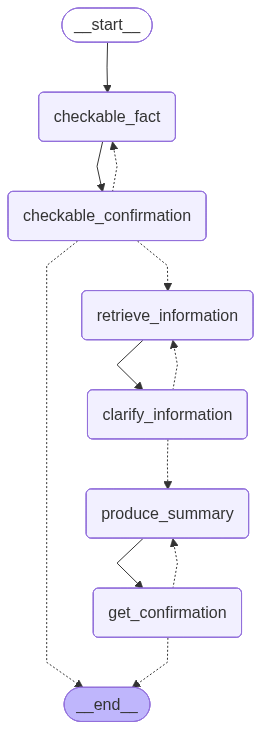

In [ ]:
# ───────────────────────────────────────────────────────────────────────
# CLAIM GRAPH
# ───────────────────────────────────────────────────────────────────────
from claim_nodes import checkable_fact,checkable_confirmation,retrieve_information,clarify_information,produce_summary,get_confirmation
from langgraph.graph import StateGraph, START, END
from state_scope import AgentStateClaim

claim = StateGraph(AgentStateClaim)

claim.add_node("checkable_fact", checkable_fact)
claim.add_node("checkable_confirmation", checkable_confirmation)
claim.add_node("retrieve_information", retrieve_information)
claim.add_node("clarify_information", clarify_information)
claim.add_node("produce_summary", produce_summary)
claim.add_node("get_confirmation", get_confirmation)

# Entry point
claim.add_edge(START, "checkable_fact")
claim.add_edge("checkable_fact", "checkable_confirmation")
claim.add_edge("retrieve_information", "clarify_information")
claim.add_edge("produce_summary", "get_confirmation")
claim.add_edge("get_confirmation", END)

claim_flow = claim.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(claim_flow.get_graph().draw_mermaid_png()))
except Exception:
    pass


## Analyse author and source

To analyse the author and source of the claim, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

First load the Faiss database, which contains allready fact-checked claims, from different Fact checking organizations. And set it up as a retriever.

In [ ]:
# ───────────────────────────────────────────────────────────────────────
# LOAD FAISS DATABASE WITH VERIFIED CLAIMS
# ───────────────────────────────────────────────────────────────────────

from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Load existing FAISS index
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
vectorstore = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

# Set up retriever
retriever = vectorstore.as_retriever()

### Tools section

Create a retriever tool, one that also checks the article behind the url, since only the url resides in the Faiss database. 
Furthermore the url's are seperated in ALLOWED URL's to ensure that the exact url is cited from the Database. This to prevent hallucinated url's.

In [6]:
from langchain.tools import tool
from utils import format_docs
import json

@tool
# ───────────────────────────────────────────────────────────────────────
# RETRIEVER TOOL
# ───────────────────────────────────────────────────────────────────────
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns information from the FACTors dataset.
    It returns two blocks as one string:
    1) CONTEXT: numbered snippets without URLs
    2) ALLOWED_URLS: a JSON dictionary of index -> url that the model must cite by index only
    """
    print(f"\n--retriever called, query: {query}--\n")
    docs = retriever.invoke(query)
    context_block = format_docs(docs)

    # Build a list of allowed URLs, and index them.
    urls = [d.metadata.get("url", "") for d in docs if d.metadata.get("url")]
    allowed = dict(enumerate(urls))
    print(f"Allowed URLs: {allowed}")

    # Return a single string so your existing tool plumbing still works.
    return (
        "CONTEXT (read-only; do NOT copy or invent URLs):\n"
        f"{context_block}\n\n"
        "ALLOWED_URLS (index -> url):\n"
        f"{json.dumps(allowed, indent=2)}\n\n"
        "INSTRUCTIONS: When citing, use indices from ALLOWED_URLS only (e.g., [0], [2]). "
        "Do not output raw URLs unless they come from ALLOWED_URLS."
    )

# ───────────────────────────────────────────────────────────────────────
# TAVILY SEARCH TOOL (new)
# ───────────────────────────────────────────────────────────────────────
@tool
def tavily_search(query: str) -> str:
    """
    General-purpose web search using Tavily.
    Use this when the user gives a source (URL, outlet, author, platform) and subject.
    Returns a JSON-like text block with titles, urls and snippets.
    """
    print(f"\n--tavily_search called, query: {query}--\n")
    if not query or not query.strip():
        return "No query provided."

    resp = tavily_client.search(
        query=query,
        max_results=5,
        search_depth="advanced",
        include_raw_content=False,
    )

    # resp looks like: {"results": [...], "query": "...", ...}
    # To match your current pattern, we return a single string.
    results = resp.get("results", [])
    return json.dumps(
        {
            "SOURCE": "tavily",
            "query": query,
            "results": results,
            "INSTRUCTIONS": (
                "Cite using the URLs in `results`. Do NOT invent URLs. "
                "Prefer the most relevant/high-authority result."
            ),
        },
        indent=2,
    )


# ───────────────────────────────────────────────────────────────────────
# BIND BOTH TO LLM
# ───────────────────────────────────────────────────────────────────────
tools = [retriever_tool, tavily_search]
llm_tools = llm.bind_tools(tools)

# Dict for lookup by name
tools_dict = {our_tool.name: our_tool for our_tool in tools}
print(f"\n--tools registered: {list(tools_dict.keys())}--\n")




--tools registered: ['retriever_tool', 'tavily_search']--



### Functions of all the nodes in Author and Source analysis

These functions are all the nodes in the author and source graph and also show the edges in case of conditional nodes.

In [ ]:
#%%writefile ./src/source_nodes.py

from prompts import retrieve_claims_prompt, match_check_prompt, identify_source_prompt, primary_source_prompt, select_primary_source_prompt, research_prompt
from langchain_core.messages import HumanMessage, ToolMessage,AIMessage
from state_scope import AgentStateSource, ConfirmationMatch, GetSource, PrimarySourcePlan, PrimarySourceSelection, ResearchPlan

# ───────────────────────────────────────────────────────────────────────
# CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

def claim_matching(stateSource: AgentStateSource) -> Command[Literal["match_or_continue"]]:
    
    """ Call the retriever tool iteratively to find if similar claims have already been researched. """

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get the summary of the previous steps
    summary = stateSource.get("summary", "")
    subject = stateSource.get("subject", "")

    # System prompt for checkability
    prompt = retrieve_claims_prompt.format(
        summary=summary,
        subject=subject,
        messages=conversation_history
    )
   
    # Start with a single HumanMessage
    human = HumanMessage(content=prompt)

    # First model call: only the prompt
    result = llm_tools.invoke([human])

    # Keep a log in state (messages must be BaseMessage objects)
    conversation_history.append(result)   

    # Iterate tool calls
    while getattr(result, "tool_calls", None):

        # empty tool messages list to contain tool outputs
        tool_msgs: List[ToolMessage] = []
        
        # loop over echt tool call
        for t in result.tool_calls:
            name = t["name"]
            args = t.get("args") or {}

            # invoke the tool
            out = tools_dict[name].invoke(args)

            # append tool output as ToolMessage
            tool_msgs.append(
                ToolMessage(
                    tool_call_id=t["id"],
                    name=name,
                    content=str(out),
                )
            )

        # Next model call, and decide if more tool calls are needed
        result = llm_tools.invoke([human, result, *tool_msgs])
      
        print(result.content)
        print("Do one of the claims match? Or do you want to continue researching?")

        # Log messages to conversation history
        conversation_history.append(result)


    return Command( 
            update={
                "goto":"match_or_continue",
                "messages": conversation_history
            }
    )  

# ───────────────────────────────────────────────────────────────────────
# MATCHED OR CONTUE RESEARCH NODE
# ───────────────────────────────────────────────────────────────────────

def match_or_continue(stateSource: AgentStateSource) -> Command[Literal["get_source", "__end__"]]:
   
    """ Decide whether to continue researching or end the process if a matching claim was found."""

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(ConfirmationMatch, method="json_mode")

    # System prompt for checkability
    prompt =  match_check_prompt.format(
        messages=conversation_history,
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # print output
    print(f"confirmed: {result.match}")
    print(f"explanation: {result.explanation}")

    if result.match:
        print("Since this claim has already been researched, we will end the process here.")
        return Command(
                goto=END, 
                update={
                    "match": result.match,
                    "explanation": result.explanation,
                    "messages": conversation_history,  
                }
        )       
    else:
        print("Since no matching claim was found, we'll continue researching.")
        print("Do you have a URL for the source of the claim? If so, please share it.")
        print("If not, could you tell me who the author/ source is and what medium the claim appeared in (e.g., article, video, social media post)?")
        return Command(
                goto="get_source", 
                update={
                    "explanation": result.explanation,
                    "messages": conversation_history,  
                }
        )
    
# ───────────────────────────────────────────────────────────────────────
# RETRIEVE SOURCE
# ───────────────────────────────────────────────────────────────────────

def get_source(stateSource: AgentStateSource) -> Command[Literal["get_primary_source"]]:
   
    """ Ask the user for the  source of the claim if no match was found."""

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(GetSource, method="json_mode")

    # System prompt for checkability
    prompt  =  identify_source_prompt.format(
        messages=conversation_history,
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # Ask more details on the source
    if {result.claim_source}!= "":
        print(f"Is the author/ source {result.claim_source} an expert, a lobiest, an NGO, government, opposition, civil service, think tank, a company or a citizen?")
    else:
        print("Do you know if the author is an expert, a lobiest, an NGO, government, opposition, civil service, think tank, a company or a citizen?")
    
    # Ask for the primary source
    print("Do you know if this is the orignal primary source? If not do you know the original source? If so tell me or add a url")

    return Command(
            goto=END, 
            update={
                "claim_source": result.claim_source,
                "claim_url": result.claim_url,
                "messages": conversation_history,
            }
    ) 

# ───────────────────────────────────────────────────────────────────────
# GET MORE INFO
# ───────────────────────────────────────────────────────────────────────

def get_primary_source(stateSource: AgentStateSource) -> Command[Literal["research_claim","locate_primary_source"]]:
   
    """ Ask the user for the original primary source of the claim, and more background on the source """

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(PrimarySourcePlan, method="json_mode")

    # System prompt for checkability
    prompt  = primary_source_prompt.format(
        messages=conversation_history,
        user_answer=user_answer,
        summary = stateSource.get("summary", ""),
        subject = stateSource.get("subject", ""),
        claim_source=stateSource.get("claim_source", ""),
        claim_url = stateSource.get("claim_url", "")
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)

    # Print the output
    print(f"primary source: {result.primary_source}")
    print(f"claim source: {result.claim_source}")
    print(f"search queries: {result.search_queries}")

    # print output
    if result.primary_source:
        return Command(
            goto="research_claim", 
            update={
                "primary_source": result.primary_source,
                "claim_source": result.claim_source,
                "search_queries": result.search_queries,
                "messages": conversation_history,
            }
        )    
    else:
        return Command(
            goto="locate_primary_source",
            update={
                "primary_source":result.primary_source,
                "claim_source": result.claim_source,
                "search_queries": result.search_queries,
                "messages": conversation_history,
            }
        )  
    
# ───────────────────────────────────────────────────────────────────────
# LOCATE PRIMARY SOURCE
# ───────────────────────────────────────────────────────────────────────

def locate_primary_source(stateSource: AgentStateSource) -> Command[Literal["select_primary_source"]]:
    
    """ Run Tavily for each prepared query and store all results. """

    # Get the context from stateSource
    conversation_history = list(stateSource.get("messages", []))
    search_queries = stateSource.get("search_queries", []) or []

    tavily_results = []

    # Loop over the search_queries
    for q in search_queries:
        if not q:
            continue

        tavily_tool = tools_dict.get("tavily_search")
        if tavily_tool is None:
            continue

        print(f"\n-- locate_primary_source: running tavily_search for: {q} --")
        tool_output = tavily_tool.invoke({"query": q})

        tavily_results.append({
            "query": q,
            "result": tool_output,
        })

        #show the output
        print(tool_output)

        conversation_history.append(
            ToolMessage(
                name="tavily_search",
                content=str(tool_output),
                tool_call_id=f"tavily-{hash(q)}",
            )
        )

    # write into state
    # Do you think one of these resources is the primary source?
    return Command(
        goto="select_primary_source",
        update={
            "tavily_context": tavily_results,
            "messages": conversation_history,
        },
    )


# ───────────────────────────────────────────────────────────────────────
# SELECT PRIMARY SOURCE
# ───────────────────────────────────────────────────────────────────────

def select_primary_source(stateSource: AgentStateSource) -> Command[Literal["research_claim"]]:
   
    """ pick the best / most likely primary source. """

    # Use structured output 
    structured_llm = llm.with_structured_output(PrimarySourceSelection, method="json_mode")

    conversation_history = list(stateSource.get("messages", []))
    tavily_context = stateSource.get("tavily_context", [])
    claim_source = stateSource.get("claim_source", "")
    claim_url = stateSource.get("claim_url", "")
    summary = stateSource.get("summary", "")
    subject = stateSource.get("subject", "")

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))

    # turn tavily_context into something the LLM can read
    tavily_pretty = json.dumps(tavily_context, indent=2)

    prompt = select_primary_source_prompt.format(
        summary=summary,
        subject=subject,
        claim_source=claim_source,
        claim_url=claim_url,
        tavily_context=tavily_pretty,
        user_answer=user_answer,
        messages=conversation_history
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)

    # Print the output
    print(f"primary source: {result.primary_source}")
    print(f"claim source: {result.claim_source}")
    print(f"claim url: {result.claim_url}")

    # Add a warning if the primary source is not found
    alerts = list(stateSource.get("alerts", []))
    if not result.primary_source:
        alerts.append("primary source not found")
    

    return Command(
        goto="research_claim",
        update={
            "primary_source": result.primary_source,
            "claim_source": result.claim_source or stateSource.get("claim_source", ""),
            "claim_url": result.claim_url or stateSource.get("claim_url", ""),
            "messages": conversation_history,
            "alerts": alerts
        },
    )

# ───────────────────────────────────────────────────────────────────────
# RESEARCH CLAIM
# ───────────────────────────────────────────────────────────────────────

def research_claim(stateSource: AgentStateSource) -> Command[Literal["__end__"]]:
    
    """ create several research queries, and run tavily_search for each query """

    # Use structured output 
    structured_llm = llm.with_structured_output(ResearchPlan, method="json_mode")

    # Get all context
    conversation_history = list(stateSource.get("messages", []))

    primary_source = stateSource.get("primary_source", False)
    claim_source = stateSource.get("claim_source", "")
    claim_url = stateSource.get("claim_url", "")
    summary = stateSource.get("summary", "")
    subject = stateSource.get("subject", "")
    alerts = list(stateSource.get("alerts", []))

    # Create research queries
    prompt = research_prompt.format(
        summary=summary,
        subject=subject,
        claim_source=claim_source,
        claim_url=claim_url,
        alerts=alerts,
        messages=conversation_history
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)

    # Run Tavily for each proposed query
    research_results = []
    for q in result.research_queries:
        if not q:
            continue

        tavily_tool = tools_dict.get("tavily_search")
        if tavily_tool is None:
            continue

        print(f"\n-- research_claim: running tavily_search for: {q} --")
        tool_output = tavily_tool.invoke({"query": q})

        research_results.append({
            "query": q,
            "result": tool_output,
        })

        # add to history
        conversation_history.append(
            ToolMessage(
                name="tavily_search",
                content=str(tool_output),
                tool_call_id=f"tavily-research-{hash(q)}",
            )
        )

    # Print the output
    print(f"research queries: {result.research_queries}")
    print(f"research focus: {result.research_focus}")
    print(research_results)

    # Write everything back to state
    return Command(
        goto=END,
        update={
            "research_queries": result.research_queries,
            "research_focus": result.research_focus,
            "research_results": research_results,
            "messages": conversation_history,
        },
    )


Writing ./src/source_nodes.py


### Claim analysis graph

Build the claim analysis graph, that takes the user step by step through analysing and scoping the claim.

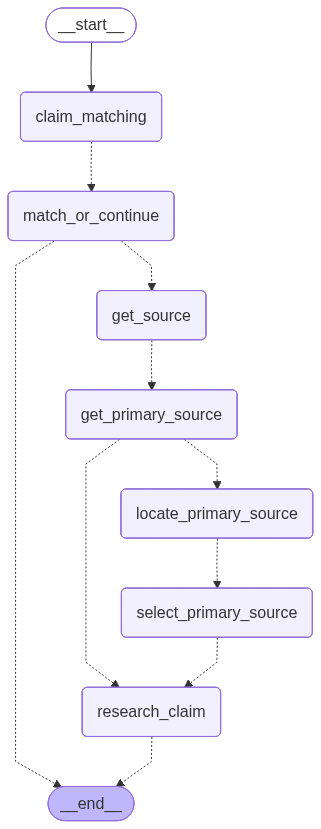

In [ ]:
# ───────────────────────────────────────────────────────────────────────
# SOURCE GRAPH
# ───────────────────────────────────────────────────────────────────────
from source_nodes import claim_matching,match_or_continue,get_source,get_primary_source,locate_primary_source,select_primary_source,research_claim
from langgraph.graph import StateGraph, START, END
from state_scope import AgentStateSource

source = StateGraph(AgentStateSource)

source.add_node("claim_matching", claim_matching)
source.add_node("match_or_continue", match_or_continue)
source.add_node("get_source", get_source)
source.add_node("get_primary_source", get_primary_source)
source.add_node("locate_primary_source", locate_primary_source)
source.add_node("select_primary_source", select_primary_source)
source.add_node("research_claim", research_claim)

# Entry point
source.add_edge(START, "claim_matching")
source.add_edge("claim_matching", "match_or_continue")
source.add_edge("match_or_continue", "get_source")
source.add_edge("get_source", "get_primary_source")
source.add_edge("locate_primary_source", "select_primary_source")
source.add_edge("research_claim", END)

source_flow = source.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(source_flow.get_graph().draw_mermaid_png()))
except Exception:
    pass


## Main program

This is the main program, tying everything together

In [ ]:
# ───────────────────────────────────────────────────────────────────────
# MAIN PROGRAM
# ───────────────────────────────────────────────────────────────────────

def running_agent():
    conversation_history: List[BaseMessage] = []

    # ───────────────────────────────────────────────────────────────────────
    # CLAIM ANALYSIS FLOW
    # ───────────────────────────────────────────────────────────────────────
    # Get initial claim and KEEP it in history before first invoke
    user_input = input("\nWhat claim do you want to investigate? ")
    conversation_history.append(HumanMessage(content=user_input))

    # Initial state
    state: AgentStateClaim = {
        "messages": conversation_history,
        "claim": user_input,
        "checkable": None,
        "subject": None,
        "quantitative": None,
        "precision": None,
        "based_on": None,
        "confirmed": False,
        "question": None,
        "alerts": [],
        "summary": None,
    }

    #show the claim
    print(f"CLAIM: {state.get('claim')}")

    # Run the graph to iteratite on the claim with input from user, this will result in a summary. 
    # This part is based on the first workflow of the EUFactcheck programme "Claim Analysis".
    result = claim_flow.invoke(state)

    # ───────────────────────────────────────────────────────────────────────
    # SOURCE AND AUTHOR FLOW
    # ───────────────────────────────────────────────────────────────────────

    # Run the graph to iteratite on the claim with input from user, this will result in a summary. 
    # This part is based on the second workflow of the EUFactcheck programme "Author and Source Analysis".
    # But we will first do some claim matching to see if similar claims have already been researched.

    # Starting state for second flow
    stateSource: AgentStateSource = {
        "messages": result.get("messages"),
        "claim": user_input,
        "checkable": True,
        "subject": result.get("subject", ""),
        "quantitative": result.get("quantitative", ""),
        "precision": result.get("precision", ""),
        "based_on": result.get("based_on", ""),
        "confirmed": False,
        "search_queries": [],
        "tavily_context":None,
        "research_focus":None,
        "research_results":[],
        "alerts": result.get("alerts", []),
        "summary": result.get("summary", ""),
        "claim_url":None,
        "claim_source":None,
        "primary_source":False,
        "match": False
    }

    # Update rolling conversation
    conversation_history = list(stateSource.get("messages", []))

    result = source_flow.invoke(stateSource)

    # Update rolling conversation
    conversation_history = list(result["messages"])

    # Persist a readable log
    with open("logging.txt", "w", encoding="utf-8") as f:
        f.write("Your Conversation Log:\n")
        for m in conversation_history:
            if isinstance(m, HumanMessage):
                f.write(f"You: {m.content}\n")
            elif isinstance(m, AIMessage):
                f.write(f"AI: {m.content}\n\n")
        f.write("End of Conversation\n")

    print("Conversation saved to logging.txt")

    
# run it
running_agent()




CLAIM: Every 3rd refugee reaches Italy on a yacht on the eastern route

=== 1. CHECKABLE? ===
POTENTIALLY CHECKABLE
The claim is a statistical assertion about a specific route and method of refugee arrival, which can be verified using migration data and transportation records.
Does this classification as a factual claim align with your understanding of the statement? Would you like to proceed with verifying it?
confirmed: True

=== 2. Evidence retrieved? ===
subject: Refugees arriving in Italy via the eastern route using yachts
quantitative: True
precision: precise
based on: unclear
question: What is the specific data source or time period you are referencing for this 1/3 statistic?
alerts: ['vague quantitative claim', 'methodological details absent', 'time period missing']
confirmed: True

=== 3. SUMMARY ===
To verify, this is a summary of our discussion: The claim states that one-third of refugees reach Italy via the eastern route by yacht. It is a precise quantitative assertion but 

c:\temp\checkmate\.venv\Lib\site-packages\pydantic\main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `list[str]` - serialized value may not be as expected [field_name='research_results', input_value='', input_type=str])
  return self.__pydantic_serializer__.to_json(



-- research_claim: running tavily_search for: UNHCR 2019 Mediterranean migration eastern route yacht methodology --

--tavily_search called, query: UNHCR 2019 Mediterranean migration eastern route yacht methodology--


-- research_claim: running tavily_search for: Frontex 2019 Italy migrant arrivals eastern route boat type statistics --

--tavily_search called, query: Frontex 2019 Italy migrant arrivals eastern route boat type statistics--


-- research_claim: running tavily_search for: Fact-check AfD claim 1/3 refugees Italy yacht 2019 site:gov OR site:un.org --

--tavily_search called, query: Fact-check AfD claim 1/3 refugees Italy yacht 2019 site:gov OR site:un.org--


-- research_claim: running tavily_search for: IOM 2019 Mediterranean migration report eastern route yacht data --

--tavily_search called, query: IOM 2019 Mediterranean migration report eastern route yacht data--


-- research_claim: running tavily_search for: Technical annex EU migration routes 2019 boat classificat